0.25


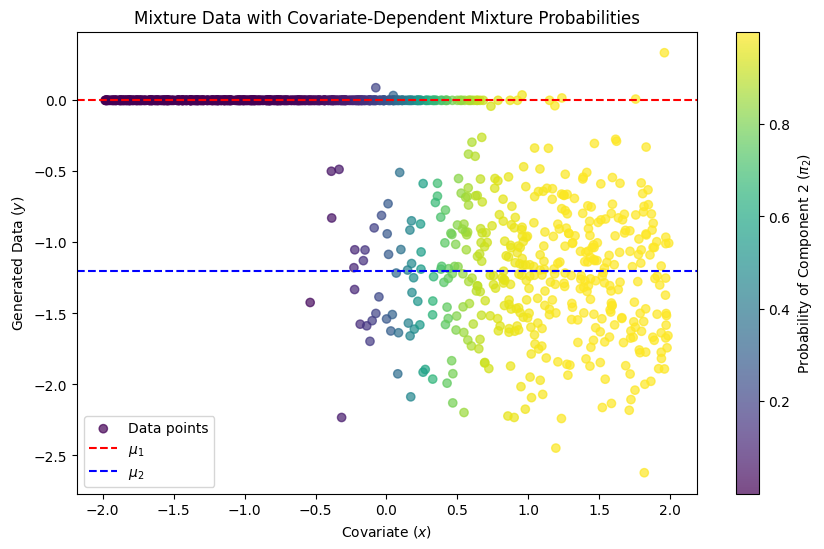

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
n_samples =1000
a, b = 5.0, -1.0  # Coefficients for logistic regression to control mixture probabilities
mu_1, sigma_1_sq = 0.0, 0.2
mu_2, sigma_2_sq = -1.20,  0.5


print(sigma_2_sq   **2 )

sebetahat= np.random.uniform( 0.1, 0.5, n_samples)
# Covariates
x = np.random.uniform(-2, 2, n_samples)

# Mixture probabilities
pi_2 = 1 / (1 + np.exp(-(a * x + b)))  # Sigmoid function for covariate-dependent pi_2
pi_1 = 1 - pi_2  # Ensure pi_1 + pi_2 = 1

# Generate data
y = np.zeros(n_samples)
betahat = np.zeros(n_samples)
c = np.zeros(n_samples, dtype=int)  # Ensure c is an integer array
for i in range(n_samples):
    # Use .item() to extract the scalar from np.random.choice
    c[i] = np.random.choice([0, 1], p=[pi_1[i], pi_2[i]])
    if c[i] == 0:
        y[i] = 0
        betahat[i]= y[i]+ np.random.normal(0, sebetahat[i] )
    else:
        y[i] = np.random.normal(mu_2,  sigma_2_sq   )
        betahat[i]= y[i]+ np.random.normal(0,   sebetahat[i] )


# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2, cmap='viridis', label='Data points', alpha=0.7)
plt.colorbar(label='Probability of Component 2 ($\pi_2$)')
plt.axhline(mu_1, color='red', linestyle='--', label='$\mu_1$')
plt.axhline(mu_2, color='blue', linestyle='--', label='$\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities')
plt.legend()
plt.show()


In [2]:
np.var(y)

np.float64(0.4586282355258604)

In [3]:
np.var(betahat)

np.float64(0.5444837684997222)

In [4]:
0.2**2+0.5**2

0.29000000000000004

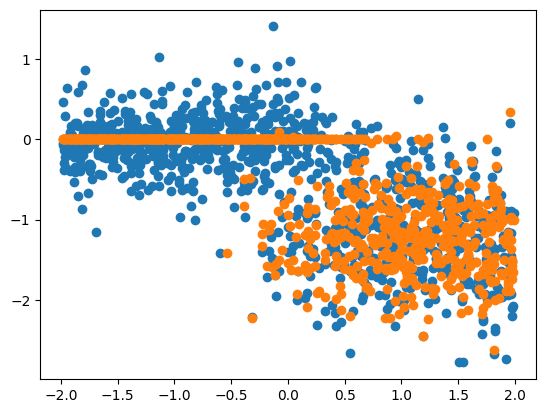

In [5]:

plt.scatter(x,betahat)
 
plt.scatter(x,y)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the MDN model
class MDN(nn.Module):
    def __init__(self, input_dim):
        super(MDN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output: logit for pi_2
        )
        self.mu_1 = 0.0  # Fixed mean for component 1
        self.sigma_1_sq = 0.0  # Fixed variance for component 1
        self.mu_2 = nn.Parameter(torch.tensor(0.0))  # Learnable mean for component 2

    def forward(self, x):
        logit_pi2 = self.fc(x).squeeze()
        pi_2 = torch.sigmoid(logit_pi2)
        pi_1 = 1 - pi_2
        return pi_1, pi_2, self.mu_2


# Loss function: Negative Log Likelihood
def mdn_loss(pi_1, pi_2, mu_2, sigma_2_sq, targets, sd_noise):
    mu_1 = torch.tensor(0.0)
    sigma_1_sq_total = sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets - mu_1) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    mixture_pdf = pi_1 * p1 + pi_2 * p2
    return -torch.mean(torch.log(mixture_pdf + 1e-8))


# Compute responsibilities (gamma values) for component 2
def compute_responsibilities(pi_1, pi_2,   mu_2, sigma_2_sq, targets, sd_noise):
    sigma_1_sq_total =0 + sd_noise**2
    sigma_2_sq_total = sigma_2_sq + sd_noise**2

    p1 = (1 / torch.sqrt(2 * torch.pi * sigma_1_sq_total)) * torch.exp(-0.5 * ((targets ) ** 2) / sigma_1_sq_total)
    p2 = (1 / torch.sqrt(2 * torch.pi * sigma_2_sq_total)) * torch.exp(-0.5 * ((targets - mu_2) ** 2) / sigma_2_sq_total)

    return (pi_2 * p2) / (pi_1 * p1 + pi_2 * p2)
  
# Perform the M-step to update sigma_2^2
def m_step_sigma2(gamma_2, mu_2, targets, sd_noise):
    residuals_sq = (targets - mu_2) ** 2
    sigma_0_sq = sd_noise**2
    numerator = torch.sum(( gamma_2 )* (residuals_sq - sigma_0_sq))
    denominator = torch.sum(( gamma_2 ))
    return torch.clamp(numerator / denominator, min=1e-6)


# Generate training data
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(betahat, dtype=torch.float32)
obs_sd_noise = torch.tensor(sebetahat, dtype=torch.float32)

# Initialize model and optimizer
model = MDN(input_dim=1)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)

# Training loop
n_epochs = 1000
sigma_2_sqe = torch.tensor(1, requires_grad=False)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    pi_1, pi_2, mu_2e = model(x_tensor)

    gamma_2 = compute_responsibilities(
        pi_1=pi_1, pi_2=pi_2,
       
        mu_2=mu_2e, 
        sigma_2_sq=sigma_2_sqe,
        targets=y_tensor,
        sd_noise=obs_sd_noise
    ) 
    with torch.no_grad():
        sigma_2_sqe = m_step_sigma2( gamma_2, mu_2e, y_tensor, obs_sd_noise)

    loss = mdn_loss(pi_1, pi_2, mu_2e, sigma_2_sqe, y_tensor, obs_sd_noise)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Sigma_2^2: {sigma_2_sqe.item()}")

# Evaluation



Epoch 0, Loss: 1.262682318687439, Sigma_2^2: 1.2752976417541504
Epoch 100, Loss: 0.6219412088394165, Sigma_2^2: 0.2847173810005188
Epoch 200, Loss: 0.5909045338630676, Sigma_2^2: 0.19763202965259552
Epoch 300, Loss: 0.5907361507415771, Sigma_2^2: 0.19495445489883423
Epoch 400, Loss: 0.5905818343162537, Sigma_2^2: 0.19459407031536102
Epoch 500, Loss: 0.590430736541748, Sigma_2^2: 0.1944679617881775
Epoch 600, Loss: 0.5897787809371948, Sigma_2^2: 0.19531694054603577
Epoch 700, Loss: 0.5897423624992371, Sigma_2^2: 0.19441668689250946
Epoch 800, Loss: 0.5893478393554688, Sigma_2^2: 0.1949247121810913
Epoch 900, Loss: 0.5889212489128113, Sigma_2^2: 0.1946934014558792


In [7]:
model.eval()
with torch.no_grad():
    pi_1, pi_2, mu_2e = model(x_tensor)

pi_np = pi_2.detach().numpy()
mu_2e= mu_2e.detach().numpy()
sigma_prior = np.sqrt(sigma_2_sqe.detach().numpy())/2


post_mean = np.zeros_like(betahat)
post_var = np.zeros_like(betahat)
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from posterior_computation import *

for i in range(len(betahat)):
        post_mean[i], post_var[i] = posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( 1-pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )
post_mean2= post_var+ post_mean**2 

In [8]:
posterior_point_mass_normal(
            betahat=betahat[i],
            sebetahat=sebetahat[i],
            pi=( pi_np[i]),  # Scalar pi for each observation
            mu0=0,  # Fixed mean for the point mass
            mu1=mu_2e,  # Global parameter
            sigma_0=sigma_prior  # Global parameter
            )

(np.float64(-1.3677197279729552), np.float64(0.02531982633436097))

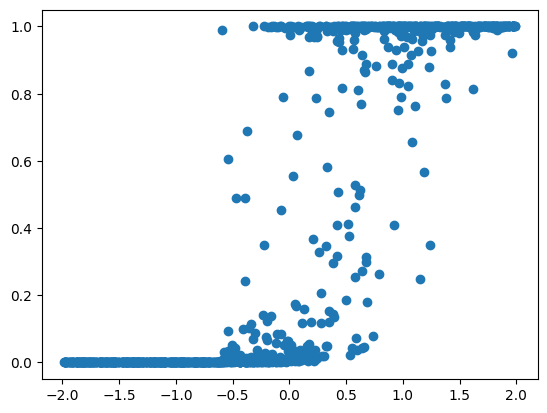

In [9]:
plt.scatter(x,gamma_2.detach().numpy() )

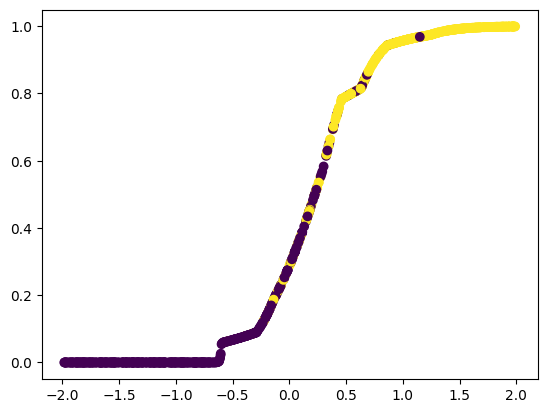

In [10]:
plt.scatter(x,pi_2.detach().numpy(), c=c )

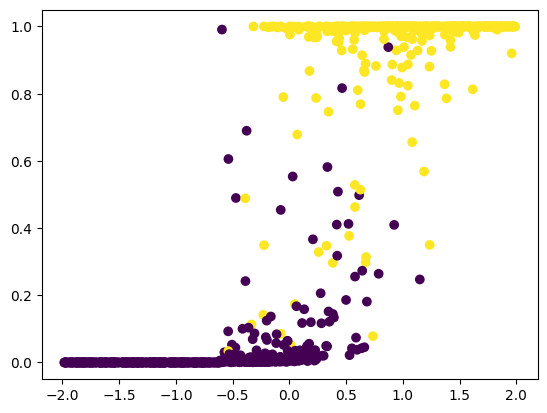

In [11]:
plt.scatter(x,gamma_2.detach().numpy(), c=c )

In [12]:
gamma_2.detach().numpy() 

array([8.06968289e-15, 9.91894245e-01, 9.99607384e-01, 1.28703181e-09,
       9.93112504e-01, 1.30536184e-02, 4.22546221e-03, 1.54767337e-03,
       2.31529609e-03, 9.99750793e-01, 1.20346315e-39, 1.21309541e-01,
       0.00000000e+00, 8.20637774e-03, 2.33994285e-03, 9.88258958e-01,
       6.55855715e-01, 1.96955829e-09, 0.00000000e+00, 9.99999762e-01,
       9.99998927e-01, 9.93013144e-01, 7.64910986e-38, 0.00000000e+00,
       1.93357572e-03, 4.05687205e-02, 9.97202098e-01, 4.89574999e-01,
       9.03938114e-19, 1.41737953e-01, 1.00000000e+00, 9.99901831e-01,
       1.02934253e-03, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       9.62097406e-01, 1.27610918e-02, 4.54074442e-01, 9.99749184e-01,
       9.99993384e-01, 0.00000000e+00, 2.84122725e-11, 3.05638609e-40,
       9.95818794e-01, 1.00000000e+00, 9.98426259e-01, 9.32547390e-01,
       8.15606680e-27, 7.32494729e-31, 1.39973545e-02, 9.99206662e-01,
       0.00000000e+00, 1.43841418e-04, 9.99995828e-01, 4.88597125e-01,
      

In [13]:
tt= (betahat-mu_2)**2

print(sum(( gamma_2.detach().numpy()* (tt))))
print(sum(gamma_2.detach().numpy()* (sebetahat**2)))
sum(gamma_2.detach().numpy())

130.10685762139104
45.5671643941918


np.float32(436.61774)

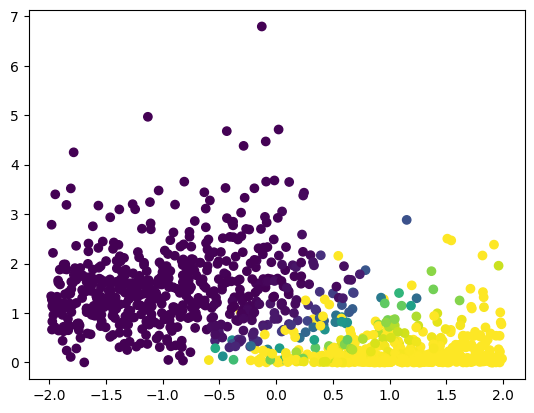

In [14]:
plt.scatter(x,tt,c=gamma_2.detach().numpy() )


In [15]:
sigma_2_sq**2

0.25

In [16]:
sigma_2_sqe.detach().numpy()

array(0.19350158, dtype=float32)

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

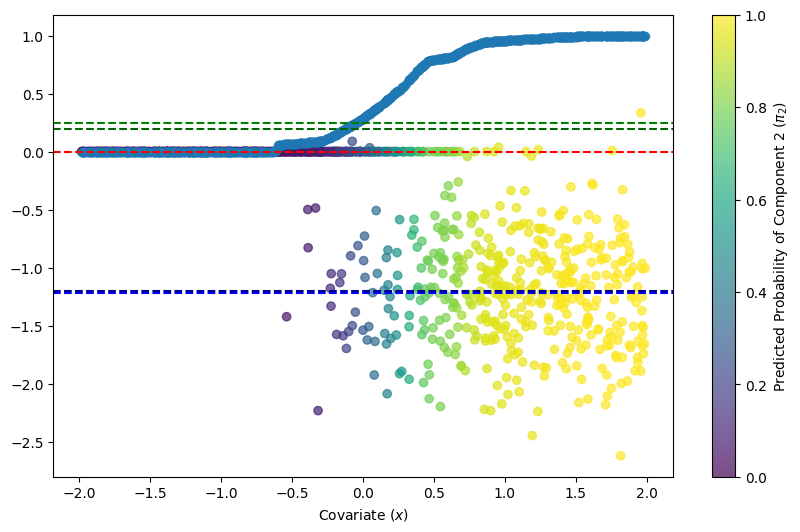

In [17]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=pi_2.numpy(), cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x, pi_2,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(mu_2e , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq   **2 , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( sigma_2_sqe.detach().numpy(), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


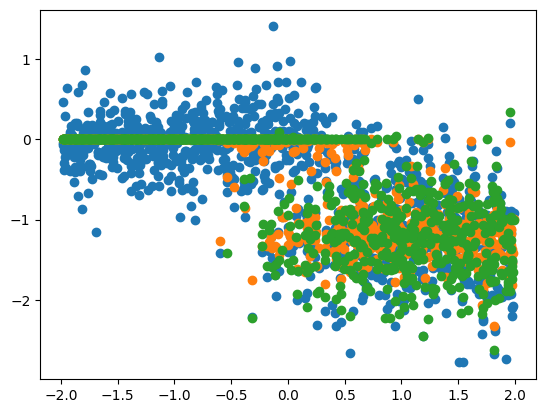

In [18]:
plt.scatter(x,betahat
            )
plt.scatter(x, post_mean)
plt.scatter(x, y)

(array([525.,  18.,   8.,   8.,   8.,   6.,   4.,   8.,  16., 399.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

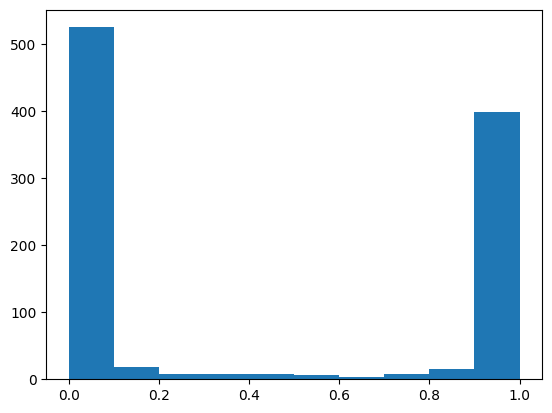

In [19]:
plt.hist(gamma_2.detach().numpy() )

In [20]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from empirical_mdn import *
from covaraite_moderated_generalized_binary import *

In [22]:
res = cgb_posterior_means(x, betahat, sebetahat)

Epoch 0, Loss: 1.2710351943969727, Sigma_2^2: 1.3403631448745728
Epoch 100, Loss: 0.6172284483909607, Sigma_2^2: 0.2754915654659271
Epoch 200, Loss: 0.590803861618042, Sigma_2^2: 0.19339551031589508
Epoch 300, Loss: 0.5907241702079773, Sigma_2^2: 0.1928398311138153
Epoch 400, Loss: 0.5906210541725159, Sigma_2^2: 0.19258610904216766
Epoch 500, Loss: 0.5903797745704651, Sigma_2^2: 0.19247613847255707
Epoch 600, Loss: 0.5897418856620789, Sigma_2^2: 0.1916050761938095
Epoch 700, Loss: 0.5885156989097595, Sigma_2^2: 0.19000867009162903
Epoch 800, Loss: 0.5874500870704651, Sigma_2^2: 0.19491420686244965
Epoch 900, Loss: 0.5867847800254822, Sigma_2^2: 0.1918802261352539


In [28]:
mu_2

-1.2

In [26]:
plt.scatter(x, res.pi_np)

AttributeError: 'tuple' object has no attribute 'pi_np'

In [25]:
# Visualize predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c= res.pi, cmap='viridis', alpha=0.7, label='Data points')
plt.scatter(x,  res.pi,  alpha=0.7 )
plt.colorbar(label='Predicted Probability of Component 2 ($\pi_2$)')
plt.axhline(0.0, color='red', linestyle='--', label='Fixed $\mu_1$')
plt.axhline(res.mu_1 , color='blue', linestyle='--', label='Predicted $\mu_2$')

plt.axhline(mu_2, color='darkblue', linestyle='--', label='Predicted $\mu_2$')
plt.axhline(sigma_2_sq    , color='green', linestyle='--', label='Predicted $\mu_2$')

plt.axhline( np.sqrt( res.sigma_0 ), color='darkgreen', linestyle='--', label='Predicted $\mu_2$')
plt.xlabel('Covariate ($x$)')
plt.ylabel


AttributeError: 'tuple' object has no attribute 'pi'

<Figure size 1000x600 with 0 Axes>

In [27]:
res.mu_1

array(-0.09927814, dtype=float32)

In [29]:
mu_2

-1.2

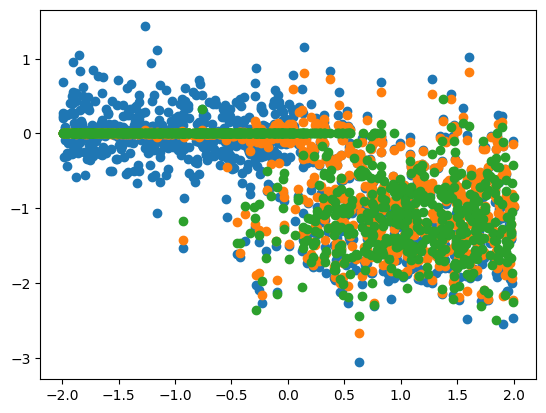

In [ ]:
plt.scatter(x,betahat
            )
plt.scatter(x, res.post_mean)
plt.scatter(x, y)